## Imports

In [1]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from collections import Counter
from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

import optuna

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
tqdm.pandas()

sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.simplefilter('ignore')

import random
random.seed(42)

## Load Data

In [3]:
INPUT_DIR = 'C:\projects\linking-writing\data'

train_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')
train_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')
test_logs = pd.read_csv(f'{INPUT_DIR}/test_logs.csv')

ss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [4]:
train_logs.shape, train_scores.shape, test_logs.shape, ss_df.shape

((8405898, 11), (2471, 2), (6, 11), (3, 2))

In [5]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [6]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [7]:
train_scores.describe()

,score
count,2471.000000
mean,3.711251
std,1.024937
min,0.500000
25%,3.000000
50%,4.000000
75%,4.500000
max,6.000000


## EDA

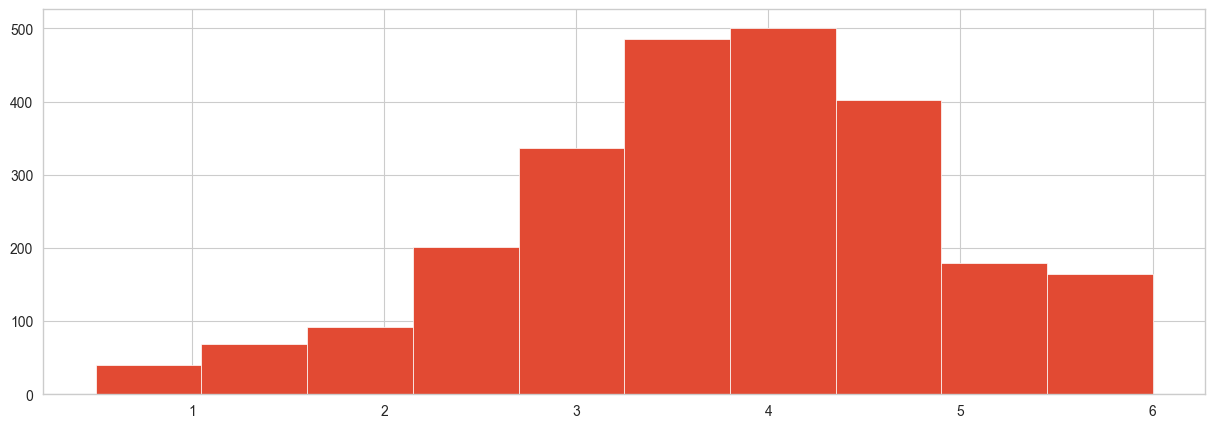

In [8]:
plt.figure(figsize=(15, 5))
train_scores['score'].hist()
plt.show()

In [9]:
train_scores['score'].value_counts()

score
4.0    501
3.5    486
4.5    402
3.0    336
2.5    201
5.0    179
5.5    128
2.0     92
1.5     69
6.0     37
1.0     35
0.5      5
Name: count, dtype: int64

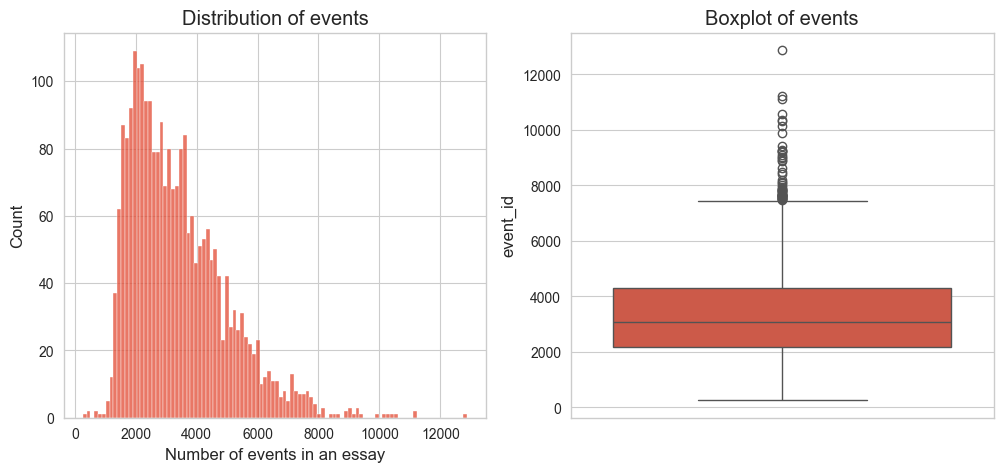

In [10]:
event_stats = train_logs.groupby("id")['event_id'].count()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of events')
ax[0].set_xlabel('Number of events in an essay')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

In [11]:
event_stats.describe()

count     2471.000000
mean      3401.820316
std       1578.850387
min        262.000000
25%       2193.500000
50%       3082.000000
75%       4301.000000
max      12876.000000
Name: event_id, dtype: float64

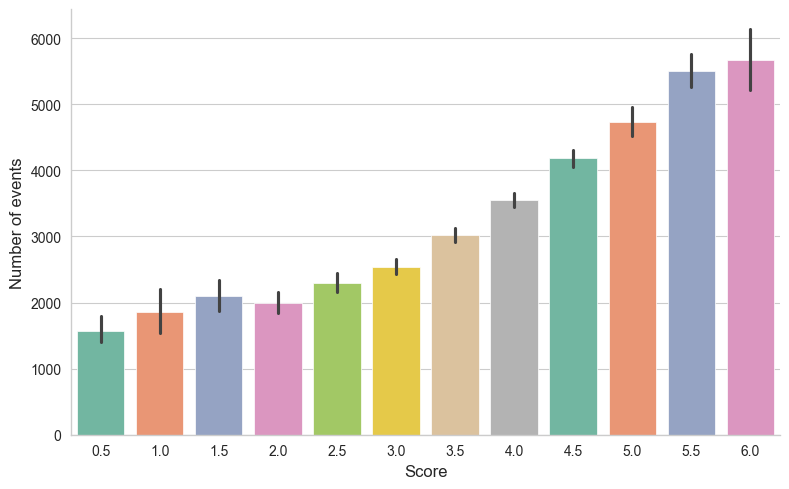

In [12]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5 ,palette="Set2" )
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.show()

In [13]:
tmp = train_logs["up_time"] - train_logs["down_time"]
results = (tmp == train_logs["action_time"])
results.value_counts()

True    8405898
Name: count, dtype: int64

In [14]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [15]:
train_logs_scores_df = train_logs.merge(train_scores, on='id', how='left')
train_logs_scores_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [16]:
train_logs_scores_df.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count', 'score'],
      dtype='object')

In [17]:
train_logs_agg_df = train_logs_scores_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count', 'score']].mean().reset_index()

In [18]:
train_logs_agg_df

,id,down_time,up_time,action_time,cursor_position,word_count,score
0,001519c8,8.481808e+05,8.482970e+05,116.246774,711.163473,128.116152,3.5
1,0022f953,5.188553e+05,5.189676e+05,112.221271,776.205786,182.714751,3.5
2,0042269b,8.284918e+05,8.285936e+05,101.837766,731.611702,194.772727,6.0
3,0059420b,7.854830e+05,7.856049e+05,121.848329,542.537275,103.618895,2.0
4,0075873a,7.133542e+05,7.134781e+05,123.943896,600.050968,125.082971,4.0
...,...,...,...,...,...,...,...
2466,ffb8c745,7.361019e+05,7.362073e+05,105.437856,774.000633,256.353661,3.5
2467,ffbef7e5,8.419662e+05,8.420485e+05,82.266129,1022.078725,223.013057,4.0
2468,ffccd6fd,1.229015e+06,1.229091e+06,75.605615,1309.085537,157.589292,1.5
2469,ffec5b38,5.765185e+05,5.766078e+05,89.277915,1192.640962,205.917027,5.0


In [19]:
def plot_dist_box(data, target):
    
    color = choice(color_pal)
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the distribution plot on the first subplot
    sns.histplot(data, ax=axes[0], color=color)
    axes[0].set_title('Distribution Plot')

    # Plot the box plot on the second subplot
    sns.boxplot(data, ax=axes[1], color=color)
    axes[1].set_title('Box Plot')
    
    # Plot the box plot on the second subplot
    sns.ecdfplot(data, ax=axes[2], color=color)
    axes[2].set_title('CDF Plot')
    
    # Plot the box plot on the second subplot
    sns.scatterplot(x=data, y=target, ax=axes[3], color=color)
    axes[3].set_title('Scatter Plot')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

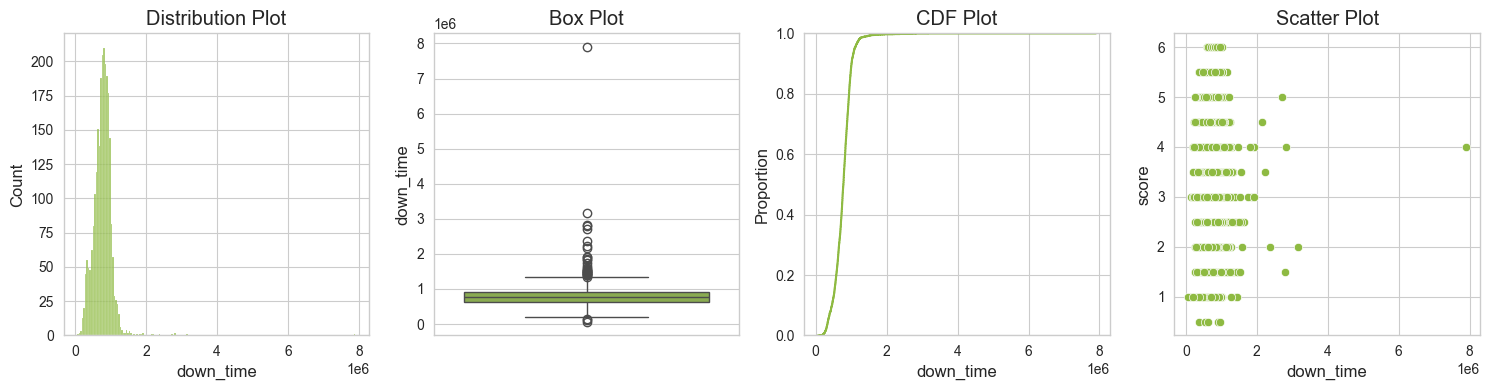

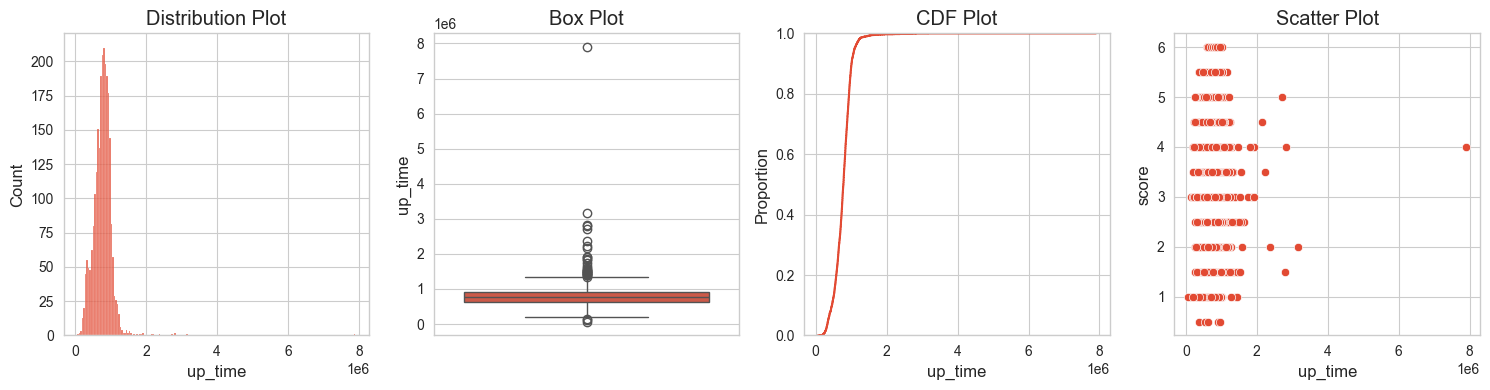

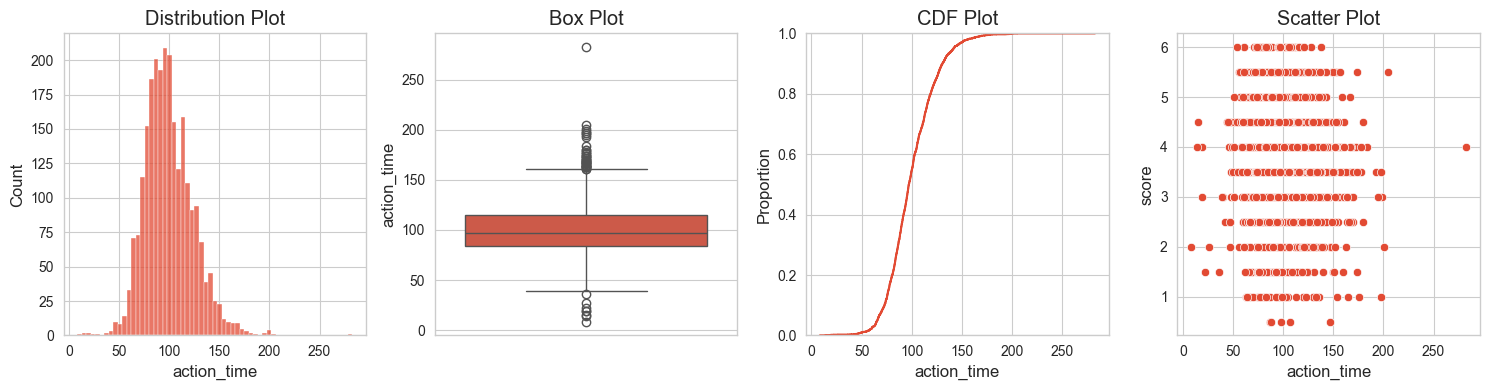

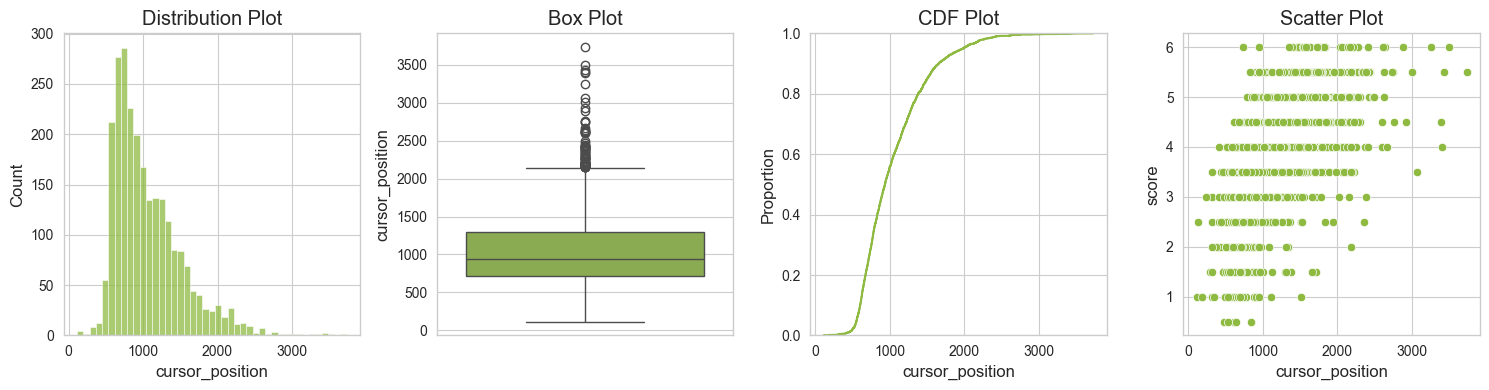

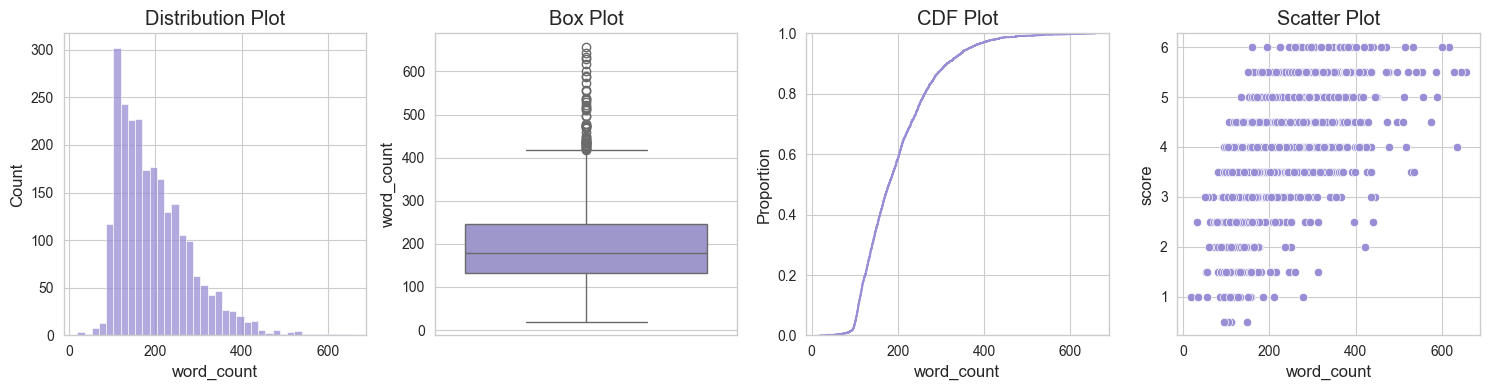

In [20]:
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
for col in num_cols:
    plot_dist_box(train_logs_agg_df[col], train_logs_agg_df['score'])

## Feature Engineering

In [21]:
from collections import defaultdict
from scipy.stats import kurtosis

class Preprocessor:
    
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        
        self.idf = defaultdict(float)
#         self.gaps = [1, 2]
    
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret


    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret


    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret


    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    def make_feats(self, df):
        
        print("Starting to engineer features")
        
        # initialize features dataframe
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        
        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', kurtosis]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', kurtosis]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', kurtosis]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', kurtosis])
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                    
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']
        
        print("Done!")
        return feats

In [22]:
preprocessor = Preprocessor(seed=42)

print("Engineering features for training data")

train_feats = preprocessor.make_feats(train_logs)

print()
print("-"*25)
print("Engineering features for test data")
print("-"*25)
test_feats = preprocessor.make_feats(test_logs)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|██████████| 33/33 [02:35<00:00,  4.71s/it, column=word_count_change100, method=kurtosis]     


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 6464.63it/s]


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 6610.25it/s]


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 7351.42it/s]


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 4560.55it/s]


Engineering input words data
Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|██████████| 33/33 [00:01<00:00, 23.34it/s, column=word_count_change100, method=kurtosis]     


Engineering activity counts data


100%|██████████| 3/3 [00:00<?, ?it/s]


Engineering event counts data


100%|██████████| 3/3 [00:00<00:00, 2995.93it/s]


Engineering text change counts data


100%|██████████| 3/3 [00:00<00:00, 3014.59it/s]


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<?, ?it/s]

Engineering input words data
Engineering ratios data
Done!


In [23]:
train_feats.shape

(2471, 287)

In [24]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

['action_time_gap1_kurtosis',
 'cursor_position_change1_kurtosis',
 'word_count_change1_kurtosis',
 'action_time_gap2_kurtosis',
 'cursor_position_change2_kurtosis',
 'word_count_change2_kurtosis',
 'action_time_gap3_kurtosis',
 'cursor_position_change3_kurtosis',
 'word_count_change3_kurtosis',
 'action_time_gap5_kurtosis',
 'cursor_position_change5_kurtosis',
 'word_count_change5_kurtosis',
 'action_time_gap10_kurtosis',
 'cursor_position_change10_kurtosis',
 'word_count_change10_kurtosis',
 'action_time_gap20_kurtosis',
 'cursor_position_change20_kurtosis',
 'word_count_change20_kurtosis',
 'action_time_gap50_kurtosis',
 'cursor_position_change50_kurtosis',
 'word_count_change50_kurtosis',
 'action_time_gap100_kurtosis',
 'cursor_position_change100_kurtosis',
 'word_count_change100_kurtosis']

In [25]:
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)

train_feats.shape, test_feats.shape

((2471, 263), (3, 263))

In [26]:
train_agg_fe_df = train_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

In [27]:
test_agg_fe_df = test_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

In [28]:
train_agg_fe_df.head()

,id,tmp_down_time_mean,tmp_down_time_std,tmp_down_time_min,tmp_down_time_max,tmp_down_time_last,tmp_down_time_first,tmp_down_time_sem,tmp_down_time_median,tmp_down_time_sum,tmp_up_time_mean,tmp_up_time_std,tmp_up_time_min,tmp_up_time_max,tmp_up_time_last,tmp_up_time_first,tmp_up_time_sem,tmp_up_time_median,tmp_up_time_sum,tmp_action_time_mean,tmp_action_time_std,tmp_action_time_min,tmp_action_time_max,tmp_action_time_last,tmp_action_time_first,tmp_action_time_sem,tmp_action_time_median,tmp_action_time_sum,tmp_cursor_position_mean,tmp_cursor_position_std,tmp_cursor_position_min,tmp_cursor_position_max,tmp_cursor_position_last,tmp_cursor_position_first,tmp_cursor_position_sem,tmp_cursor_position_median,tmp_cursor_position_sum,tmp_word_count_mean,tmp_word_count_std,tmp_word_count_min,tmp_word_count_max,tmp_word_count_last,tmp_word_count_first,tmp_word_count_sem,tmp_word_count_median,tmp_word_count_sum
0,001519c8,848180.771998,395112.665961,4526,1801877,1801877,4526,7813.679400,891716.0,2168798234,848297.018772,395105.685655,4557,1801969,1801969,4557,7813.541359,891802.0,2169095477,116.246774,91.797374,0,2259,92,31,1.815369,112.0,297243,711.163473,439.359619,0,1539,1046,0,8.688699,727.0,1818445,128.116152,76.498372,0,256,255,0,1.512819,132.0,327593
1,0022f953,518855.347596,384959.404177,30623,1788842,1788842,30623,7771.013336,407673.0,1273271023,518967.568867,384952.728796,30853,1788969,1788969,30853,7770.878583,407789.0,1273546414,112.221271,55.431189,0,1758,127,230,1.118966,115.0,275391,776.205786,449.133174,0,1676,1519,0,9.066462,743.0,1904809,182.714751,97.763090,0,323,320,0,1.973502,186.0,448382
2,0042269b,828491.775145,489500.796565,4441,1771219,1771219,4441,7611.375322,759582.0,3426641982,828593.612911,489500.438784,4540,1771669,1771669,4540,7611.369759,759674.5,3427063183,101.837766,82.383766,0,3005,450,99,1.281007,94.0,421201,731.611702,592.769763,0,2291,491,0,9.217131,530.5,3025946,194.772727,108.935068,0,404,404,0,1.693860,193.0,805580
3,0059420b,785483.026350,385205.014399,41395,1404394,1404394,41395,9765.334758,848240.5,1222211589,785604.874679,385206.081250,41513,1404469,1404469,41513,9765.361803,848405.5,1222401185,121.848329,113.768226,0,806,75,118,2.884139,110.0,189596,542.537275,307.627200,0,1047,797,0,7.798659,593.5,844188,103.618895,61.882250,0,206,206,0,1.568777,108.5,161231
4,0075873a,713354.197550,405576.409034,78470,1662390,1662390,78470,8061.699636,686588.0,1805499474,713478.141446,405575.631746,78693,1662472,1662472,78693,8061.684185,686728.0,1805813176,123.943896,62.082013,0,701,82,223,1.234013,129.0,313702,600.050968,341.729409,0,1402,1402,0,6.792604,630.0,1518729,125.082971,77.255054,0,252,252,0,1.535610,113.0,316585


In [29]:
test_agg_fe_df.head()

,id,tmp_down_time_mean,tmp_down_time_std,tmp_down_time_min,tmp_down_time_max,tmp_down_time_last,tmp_down_time_first,tmp_down_time_sem,tmp_down_time_median,tmp_down_time_sum,tmp_up_time_mean,tmp_up_time_std,tmp_up_time_min,tmp_up_time_max,tmp_up_time_last,tmp_up_time_first,tmp_up_time_sem,tmp_up_time_median,tmp_up_time_sum,tmp_action_time_mean,tmp_action_time_std,tmp_action_time_min,tmp_action_time_max,tmp_action_time_last,tmp_action_time_first,tmp_action_time_sem,tmp_action_time_median,tmp_action_time_sum,tmp_cursor_position_mean,tmp_cursor_position_std,tmp_cursor_position_min,tmp_cursor_position_max,tmp_cursor_position_last,tmp_cursor_position_first,tmp_cursor_position_sem,tmp_cursor_position_median,tmp_cursor_position_sum,tmp_word_count_mean,tmp_word_count_std,tmp_word_count_min,tmp_word_count_max,tmp_word_count_last,tmp_word_count_first,tmp_word_count_sem,tmp_word_count_median,tmp_word_count_sum
0,0000aaaa,549253.0,298144.503219,338433,760073,760073,338433,210820.0,549253.0,1098506,549339.0,298145.917433,338518,760160,760160,338518,210821.0,549339.0,1098678,86.0,1.414214,85,87,87,85,1.0,86.0,172,0.5,0.707107,0,1,1,0,0.5,0.5,1,0.0,0.000000,0,0,0,0,0.0,0.0,0
1,2222bbbb,501229.0,298012.981358,290502,711956,290502,711956,210727.0,501229.0,1002458,501285.5,298027.830601,290548,712023,290548,712023,210737.5,501285.5,1002571,56.5,14.849242,46,67,46,67,10.5,56.5,113,0.5,0.707107,0,1,1,0,0.5,0.5,1,1.0,0.000000,1,1,1,1,0.0,1.0,2
2,4444cccc,410271.5,318587.667370,184996,635547,184996,635547,225275.5,410271.5,820543,410346.5,318614.537428,185052,635641,185052,635641,225294.5,410346.5,820693,75.0,26.870058,56,94,56,94,19.0,75.0,150,0.5,0.707107,0,1,1,0,0.5,0.5,1,0.5,0.707107,0,1,1,0,0.5,0.5,1


In [30]:
train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

#### Implementaion of paper "{ENTER}ing the Time Series {SPACE}:  Uncovering the Writing Process through  Keystroke Analyses " Section 3

In [31]:
data = []

for logs in [train_logs, test_logs]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

gc.collect()

54942

In [32]:
train_eD592674.head()

,id,largest_lantency,smallest_lantency,median_lantency,initial_pause,pauses_half_sec,pauses_1_sec,pauses_1_half_sec,pauses_2_sec,pauses_3_sec
0,001519c8,154.136,0.0,0.062,4.526,114,51,30,21,103
1,0022f953,145.899,0.0,0.061,30.623,141,37,13,19,61
2,0042269b,153.886,0.0,0.040,4.441,83,46,25,25,52
3,0059420b,101.690,0.0,0.131,41.395,178,81,34,32,55
4,0075873a,110.688,0.0,0.059,78.470,65,24,11,17,71


In [33]:
train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')

In [34]:
train_feats.shape, test_feats.shape

((2471, 317), (3, 317))

In [35]:
train_feats.head()

,id,event_id_max,up_time_max,action_time_max,action_time_min,action_time_mean,action_time_std,action_time_quantile,action_time_sem,action_time_sum,action_time_skew,action_time_kurtosis,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_quantile,cursor_position_sem,cursor_position_mean,word_count_nunique,word_count_max,word_count_quantile,word_count_sem,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_quantile,action_time_gap1_sem,action_time_gap1_sum,action_time_gap1_skew,cursor_position_change1_max,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_quantile,cursor_position_change1_sem,cursor_position_change1_sum,cursor_position_change1_skew,word_count_change1_max,word_count_change1_mean,word_count_change1_std,word_count_change1_quantile,word_count_change1_sem,word_count_change1_sum,word_count_change1_skew,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_quantile,action_time_gap2_sem,action_time_gap2_sum,action_time_gap2_skew,cursor_position_change2_max,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_quantile,cursor_position_change2_sem,cursor_position_change2_sum,cursor_position_change2_skew,word_count_change2_max,word_count_change2_mean,word_count_change2_std,word_count_change2_quantile,word_count_change2_sem,word_count_change2_sum,word_count_change2_skew,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_quantile,action_time_gap3_sem,action_time_gap3_sum,action_time_gap3_skew,cursor_position_change3_max,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_quantile,cursor_position_change3_sem,cursor_position_change3_sum,cursor_position_change3_skew,word_count_change3_max,word_count_change3_mean,word_count_change3_std,word_count_change3_quantile,word_count_change3_sem,word_count_change3_sum,word_count_change3_skew,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_quantile,action_time_gap5_sem,action_time_gap5_sum,action_time_gap5_skew,cursor_position_change5_max,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_quantile,cursor_position_change5_sem,cursor_position_change5_sum,cursor_position_change5_skew,word_count_change5_max,word_count_change5_mean,word_count_change5_std,word_count_change5_quantile,word_count_change5_sem,word_count_change5_sum,word_count_change5_skew,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_quantile,action_time_gap10_sem,action_time_gap10_sum,action_time_gap10_skew,cursor_position_change10_max,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_quantile,cursor_position_change10_sem,cursor_position_change10_sum,cursor_position_change10_skew,word_count_change10_max,word_count_change10_mean,word_count_change10_std,word_count_change10_quantile,word_count_change10_sem,word_count_change10_sum,word_count_change10_skew,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_quantile,action_time_gap20_sem,action_time_gap20_sum,action_time_gap20_skew,cursor_position_change20_max,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_quantile,cursor_position_change20_sem,cursor_position_change20_sum,cursor_position_change20_skew,word_count_change20_max,word_count_change20_mean,word_count_change20_std,word_count_change20_quantile,word_count_change20_sem,word_count_change20_sum,word_count_change20_skew,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_quantile,action_time_gap50_sem,action_time_gap50_sum,action_time_gap50_skew,cursor_position_change50_max,cursor_position

In [36]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

[]

In [37]:
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [38]:
train_feats.head()

,id,event_id_max,up_time_max,action_time_max,action_time_min,action_time_mean,action_time_std,action_time_quantile,action_time_sem,action_time_sum,action_time_skew,action_time_kurtosis,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_quantile,cursor_position_sem,cursor_position_mean,word_count_nunique,word_count_max,word_count_quantile,word_count_sem,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_quantile,action_time_gap1_sem,action_time_gap1_sum,action_time_gap1_skew,cursor_position_change1_max,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_quantile,cursor_position_change1_sem,cursor_position_change1_sum,cursor_position_change1_skew,word_count_change1_max,word_count_change1_mean,word_count_change1_std,word_count_change1_quantile,word_count_change1_sem,word_count_change1_sum,word_count_change1_skew,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_quantile,action_time_gap2_sem,action_time_gap2_sum,action_time_gap2_skew,cursor_position_change2_max,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_quantile,cursor_position_change2_sem,cursor_position_change2_sum,cursor_position_change2_skew,word_count_change2_max,word_count_change2_mean,word_count_change2_std,word_count_change2_quantile,word_count_change2_sem,word_count_change2_sum,word_count_change2_skew,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_quantile,action_time_gap3_sem,action_time_gap3_sum,action_time_gap3_skew,cursor_position_change3_max,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_quantile,cursor_position_change3_sem,cursor_position_change3_sum,cursor_position_change3_skew,word_count_change3_max,word_count_change3_mean,word_count_change3_std,word_count_change3_quantile,word_count_change3_sem,word_count_change3_sum,word_count_change3_skew,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_quantile,action_time_gap5_sem,action_time_gap5_sum,action_time_gap5_skew,cursor_position_change5_max,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_quantile,cursor_position_change5_sem,cursor_position_change5_sum,cursor_position_change5_skew,word_count_change5_max,word_count_change5_mean,word_count_change5_std,word_count_change5_quantile,word_count_change5_sem,word_count_change5_sum,word_count_change5_skew,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_quantile,action_time_gap10_sem,action_time_gap10_sum,action_time_gap10_skew,cursor_position_change10_max,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_quantile,cursor_position_change10_sem,cursor_position_change10_sum,cursor_position_change10_skew,word_count_change10_max,word_count_change10_mean,word_count_change10_std,word_count_change10_quantile,word_count_change10_sem,word_count_change10_sum,word_count_change10_skew,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_quantile,action_time_gap20_sem,action_time_gap20_sum,action_time_gap20_skew,cursor_position_change20_max,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_quantile,cursor_position_change20_sem,cursor_position_change20_sum,cursor_position_change20_skew,word_count_change20_max,word_count_change20_mean,word_count_change20_std,word_count_change20_quantile,word_count_change20_sem,word_count_change20_sum,word_count_change20_skew,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_quantile,action_time_gap50_sem,action_time_gap50_sum,action_time_gap50_skew,cursor_position_change50_max,cursor_position

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_feats['score_class'] = le.fit_transform(train_feats['score'])

In [40]:
target_col = ['score']

drop_cols = ['id', 'score_class']

train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

train_cols.__len__(), target_col.__len__()

(316, 1)

## Tuned Model

In [41]:
models_dict = {}
scores = []

test_predict_list = []
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18}

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)

    oof_valid_preds = np.zeros(train_feats.shape[0], )

    X_test = test_feats[train_cols]


    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):

        print("==-"* 50)
        print("Fold : ", fold)

        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.log_evaluation(100)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict

        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f'{fold}_{i}'] = model


    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 316) (2223, 1)
Valid : (248, 316) (248, 1)
[100]	valid_0's rmse: 0.602504
[200]	valid_0's rmse: 0.601228
[300]	valid_0's rmse: 0.604391
Fold RMSE Score :  0.5989104981550653
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 316) (2224, 1)
Valid : (247, 316) (247, 1)
[100]	valid_0's rmse: 0.524798
[200]	valid_0's rmse: 0.524814
[300]	valid_0's rmse: 0.526651
Fold RMSE Score :  0.521765643727975
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Trian : (2224, 316) (2224, 1)
Valid : (247, 316) (247, 1)
[100]	valid_0's rmse: 0.694611
[200]	valid_0's rmse: 0.694305
[300]	valid_0's rmse

In [42]:
feature_importances_values = np.asarray([model.feature_importances_ for model in models_dict.values()]).mean(axis=0)
feature_importance_df = pd.DataFrame({'name': train_cols, 'importance': feature_importances_values})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [43]:
np.mean(scores)

0.629269665249456

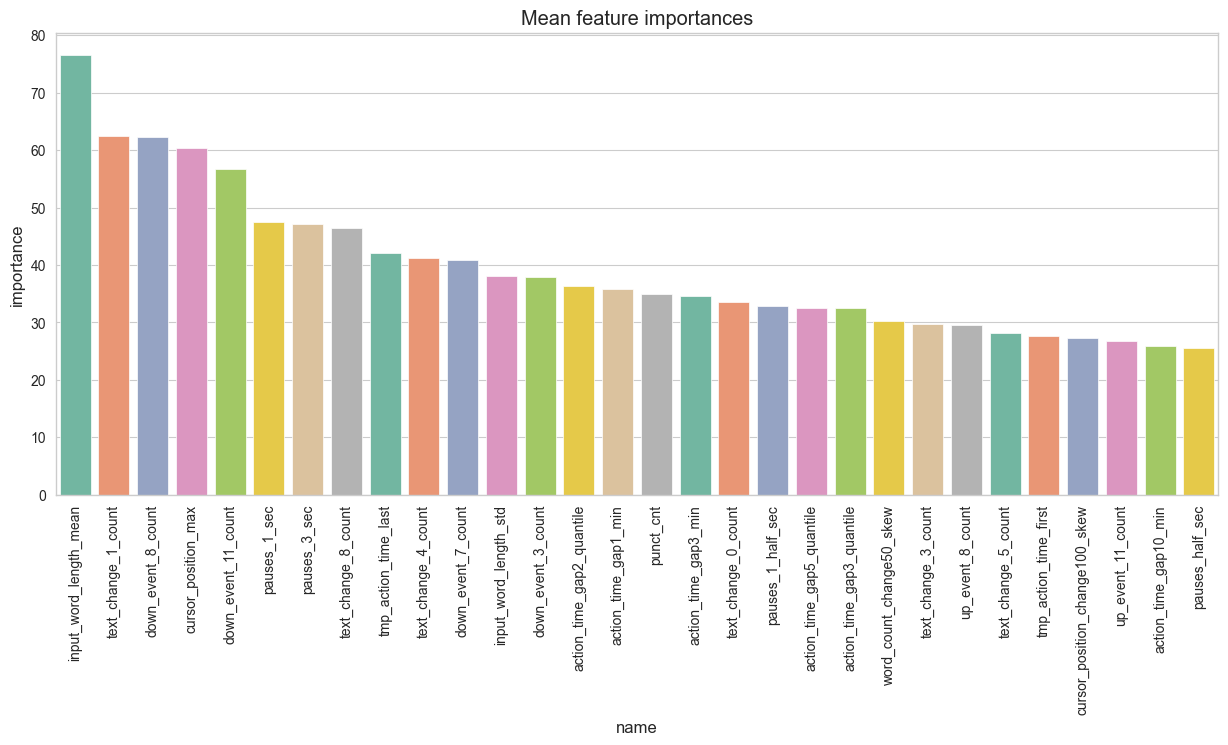

In [44]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(
    data=feature_importance_df.head(30), 
    x='name', 
    y='importance', 
    palette='Set2'  # This will use a mixed palette of colors
)

ax.set_title("Mean feature importances")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


plt.show()


In [45]:
test_feats['score'] = np.mean(test_predict_list, axis=0)

In [46]:
test_feats['score'] 

0    1.576360
1    1.522575
2    1.540358
Name: score, dtype: float64